In [1]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class PairedHDF5Dataset(Dataset):
    def __init__(self, data_dir, 
                 groundtruth_dir):
        super(PairedHDF5Dataset, self).__init__()

        # Get a list of paths
        self.data_paths = sorted(
            [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.hdf5')])
        self.groundtruth_paths = sorted(
            [os.path.join(groundtruth_dir, file) for file in os.listdir(groundtruth_dir) if file.endswith('.hdf5')])

        assert len(self.data_paths) == len(self.groundtruth_paths), "Mismatch between data and groundtruth files"

        # Calculate the cumulative sizes
        self.cumulative_sizes = []
        cum_size = 0
        for path in self.data_paths:
            with h5py.File(path, 'r') as file:
                cum_size += len(file['data'])
                self.cumulative_sizes.append(cum_size)
                
         # Define the image transformation to resize to half of the original size
        self.transform1 = transforms.Resize((1000 // 1, 513 // 1))
        self.transform2 = transforms.Resize((362 //1, 362 //1 ))


    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, index):
        # Find the correct file and local index
        file_idx = next(i for i, cum_size in enumerate(self.cumulative_sizes) if cum_size > index)
        if file_idx == 0:
            local_index = index
        else:
            local_index = index - self.cumulative_sizes[file_idx - 1]

        with h5py.File(self.data_paths[file_idx], 'r') as data_file, h5py.File(self.groundtruth_paths[file_idx],
                                                                               'r') as gt_file:
            data = torch.tensor(np.expand_dims(data_file['data'][local_index], axis=0).squeeze())
            groundtruth = torch.tensor(np.expand_dims(gt_file['data'][local_index], axis=0).squeeze())
            
        
        # Resize data and groundtruth to half of the original size
        data = self.transform1(data.unsqueeze(0))
        groundtruth = self.transform2(groundtruth.unsqueeze(0))
        
        return data.squeeze(0), groundtruth.squeeze(0)


# Usage:
train_dataset = PairedHDF5Dataset(
    'observation_train',
    'ground_truth_train'
)

validation_dataset = PairedHDF5Dataset(
    'observation_validation',
    'ground_truth_validation'
)



In [2]:
from torch.utils.data import Subset
import random

# Randomly sample 200 indices from the dataset
i = random.sample(range(len(train_dataset)), 100)
j = random.sample(range(len(validation_dataset)), 20)
# Create a subset from the train_dataset using the sampled indices
subset_dataset = Subset(train_dataset, i)
valsubset_dataset = Subset(validation_dataset, j)


In [3]:
from torch.utils.data import DataLoader

data_loader = DataLoader(subset_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(valsubset_dataset, batch_size=1, shuffle=True)

Matplotlib created a temporary cache directory at /tmp/781598.tinygpu/matplotlib-k0m6u2q_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


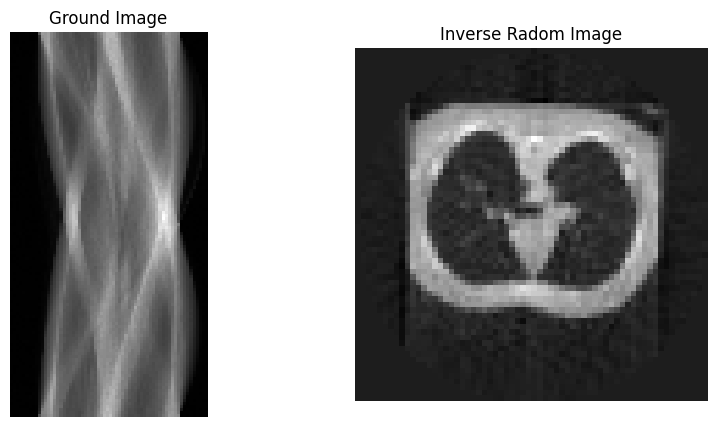

In [4]:
from skimage.transform import iradon
import matplotlib.pyplot as plt

#original_image = torch.zeros((500, 256))
for image, labels in data_loader:
    
    plt.figure(figsize=(10, 5))
    original_image = image[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[0], cmap='gray')
    plt.axis('off')
    plt.title('Ground Image')
    
    plt.subplot(1, 2, 2)
    iradom_image = iradon(image[0].T.numpy(), circle=True)
    plt.imshow(iradom_image, cmap='gray')
    plt.axis('off')
    plt.title('Inverse Radom Image')
    
    plt.show()
    break  

In [5]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 1, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*7*7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((362//1, 362//1))(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

# 测试网络结构
model = ResNet18().cuda()#

# 测试网络结构
#input_channels = 1  # 输入通道数为1，因为CT图像是灰度图
#output_channels = 1  # 输出通道数为1，因为CT图像也是灰度图
#model = UNet(input_channels, output_channels).cuda()
#print(model)


In [6]:
import torch

# 检查GPU是否可用
if torch.cuda.is_available():
    # 获取GPU设备
    device = torch.device("cuda")
    
    # 获取GPU设备的数量
    num_gpu = torch.cuda.device_count()
    
    print("Number of GPUs available:", num_gpu)
    
    for i in range(num_gpu):
        # 获取每个GPU的名称
        gpu_name = torch.cuda.get_device_name(i)
        print("GPU", i, ":", gpu_name)
        
        # 获取每个GPU的内存总量和已使用量
        total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3 # 将内存转换为GB
        allocated_memory = torch.cuda.memory_allocated(i) / 1024**3
        cached_memory = torch.cuda.memory_reserved(i) / 1024**3
        print(f"Total Memory: {total_memory:.2f} GB")
        print(f"Allocated Memory: {allocated_memory:.2f} GB")
        print(f"Cached Memory: {cached_memory:.2f} GB\n")
else:
    print("No GPU available, using CPU instead.")


Number of GPUs available: 1
GPU 0 : NVIDIA GeForce GTX 1080 Ti
Total Memory: 10.91 GB
Allocated Memory: 0.01 GB
Cached Memory: 0.02 GB



# use GV_Loss + MSE_Loss + Perceptron loss

In [7]:
def perceptron_loss(output, target):
    return torch.mean(torch.clamp(-target * output, min=0))

In [8]:
def L1_regularization(model, lambda_l1):
    l1_loss = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1*l1_loss

Epoch [1/10], Train Loss: 0.3416, Val Loss: 0.2543
Epoch [2/10], Train Loss: 0.1649, Val Loss: 0.1872
Epoch [3/10], Train Loss: 0.1319, Val Loss: 0.1545
Epoch [4/10], Train Loss: 0.1144, Val Loss: 0.1311
Epoch [5/10], Train Loss: 0.1018, Val Loss: 0.1219
Epoch [6/10], Train Loss: 0.0923, Val Loss: 0.1240
Epoch [7/10], Train Loss: 0.0858, Val Loss: 0.1021
Epoch [8/10], Train Loss: 0.0817, Val Loss: 0.0941
Epoch [9/10], Train Loss: 0.0796, Val Loss: 0.1114
Epoch [10/10], Train Loss: 0.0790, Val Loss: 0.1150
Finished Training


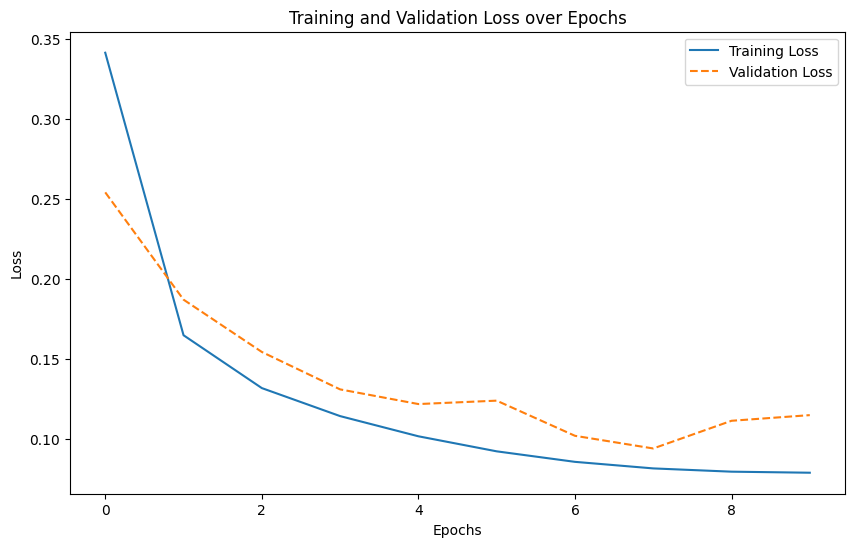

In [9]:
import matplotlib.pyplot as plt
from gradient_variance_loss import GradientVariance
import pytorch_ssim

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(data_loader), epochs=10)
criterion = nn.MSELoss()
grad_criterion = GradientVariance(patch_size = 16, cpu=False)
grad_weight = 0.02
grad_weight = torch.tensor(grad_weight).cuda()
num_epochs = 10
lambda_l1 = 5e-10


def train_model(model, data_loader, optimizer, num_epochs, val_loader=None, save_path="best_model.pth"):
    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Initialize with a high value

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(data_loader)

        for batch_idx, (data, groundtruth) in enumerate(data_loader):
            data, groundtruth = data.cuda(), groundtruth.cuda()

            optimizer.zero_grad()
            outputs = model(data.unsqueeze(0))
            loss_mse = criterion(outputs.squeeze(0), groundtruth)
            loss_grad = grad_weight * grad_criterion(outputs, groundtruth)
            loss = loss_grad + loss_mse
            loss += L1_regularization(model, lambda_l1)
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            scheduler.step()

        avg_train_loss = running_loss / total_batches
        train_loss_history.append(avg_train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for batch_idx,(data, groundtruth) in enumerate(val_loader):
                    data, groundtruth = data.cuda(), groundtruth.cuda()
                    outputs = model(data.unsqueeze(0))
                    #ssim_loss =pytorch_ssim.SSIM(window_size = 11)
                    #loss_ssim = ssim_loss(outputs, groundtruth).abs()
                    loss_mse = criterion(outputs.squeeze(0), groundtruth)
                    loss = loss_mse
                    val_running_loss += loss.item()

            avg_val_loss = val_running_loss / len(val_loader)

            # Check if this is the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), save_path)  # Save the best model

            val_loss_history.append(avg_val_loss)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    print("Finished Training")
    return train_loss_history, val_loss_history


loss_history, val_loss_history = train_model(model, data_loader, optimizer, num_epochs, val_loader)
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [10]:
def load_data_from_hdf5(filename, dataset_name="data"):
    with h5py.File(filename, 'r') as f:
        # Assuming the dataset is 3D and you want the first image
        data = f[dataset_name][-1, :, :]
    return data


phantom = load_data_from_hdf5("ground_truth_test_000.hdf5")
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()
sinogram = load_data_from_hdf5("observation_test_000.hdf5")
sinogram = torch.tensor(np.expand_dims(sinogram, axis=0).copy(), dtype=torch.float32).cuda()

In [11]:
model.eval()
reconstruction = model(sinogram.unsqueeze(0))

In [12]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """Normalize the pixel values of an image to the range [0, 1]."""
    min_val = image.min()
    max_val = image.max()

    return (image - min_val) / (max_val - min_val)


In [13]:
transform3 = transforms.Resize((362, 362))
reconstruction2 = transform3(reconstruction)
transform4 = transforms.Resize((362//8, 362//8))
phantom2 = transform4((phantom))

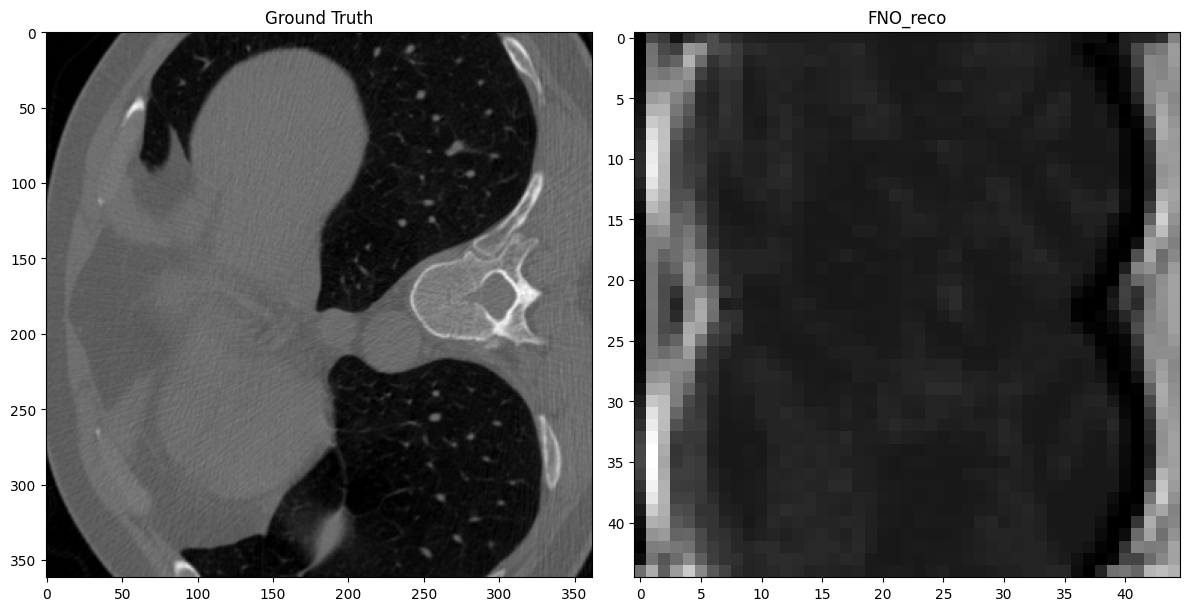

In [14]:
#reconstruction = reconstruction.detach().cpu().numpy().squeeze()
# 1. Display the original Shepp-Logan phantom.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(normalize_image(phantom.squeeze().cpu()), cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(normalize_image(reconstruction.detach().cpu().numpy().squeeze()), cmap='gray')
plt.title('FNO_reco')

plt.tight_layout()
plt.show()